# Задача


### Дан срез транзакций фирмы по доставке продуктов. Найти все интересные инсайты. 


### Также у бизнеса есть большая проблема с ненайденными товарами: клиент заказывает товары, но они заканчиваются в магазине к моменту начала сборки. Пользователи, очевидно, очень недовольны таким опытом.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from datetime import timedelta

### Время доставки

In [2]:
orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/NjRWe8Q6j3sJPA', parse_dates=[9, 10])

In [3]:
stores = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/0hbGxkhotc_CxQ')

Оценим данные по заказам

In [4]:
orders.head()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,2018-08-26 02:06:55,888330,1,226459
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41,2018-08-26 05:43:20,888394,1,226460
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11,2018-08-26 06:12:13,888420,1,226459
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01,2018-08-26 06:13:59,888422,1,226462
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48,2018-08-26 07:40:58,870688,1,226458


In [5]:
orders.shape

(720433, 14)

In [6]:
orders.dtypes

id                             int64
user_id                        int64
total_cost                   float64
cost                         float64
item_total                     int64
promo_total                  float64
total_weight                   int64
total_quantity                 int64
state                         object
shipped_at            datetime64[ns]
created_at            datetime64[ns]
ship_address_id                int64
store_id                       int64
delivery_window_id             int64
dtype: object

Добавим колонку с длительностью доставок

In [7]:
orders['deliv_time'] = orders.shipped_at - orders.created_at

Чтобы минимизировать влияние выбросов оценим медиану времени доставки и время между 25 и 75 квантилем

In [8]:
orders.deliv_time.median()

Timedelta('1 days 01:18:07')

In [9]:
orders.deliv_time.quantile(q=[0.25, 0.75])

0.25   0 days 12:06:45
0.75   3 days 13:59:53
Name: deliv_time, dtype: timedelta64[ns]

Как видим, что время доставки достаточно длительное и часто больше суток, что может негативно влиять на лояльность покупателя

Сравним данные по городам

In [10]:
orders_stores = orders.merge(stores, how = 'left', left_on = 'store_id', right_on = 'id')
orders_stores.shape

(720433, 18)

Всего городов в срезе:

In [11]:
orders_stores.city.nunique()

7

Для удобства расчетов переведем длительность доставки в часы

In [12]:
orders_stores['deliv_time'] = orders_stores.deliv_time.apply(lambda c: c.total_seconds() // 3600)
orders_stores.head()

,id_x,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,deliv_time,id_y,city,retailer_id
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,2018-08-26 02:06:55,888330,1,226459,12.0,1,1,1
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41,2018-08-26 05:43:20,888394,1,226460,10.0,1,1,1
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11,2018-08-26 06:12:13,888420,1,226459,8.0,1,1,1
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01,2018-08-26 06:13:59,888422,1,226462,12.0,1,1,1
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48,2018-08-26 07:40:58,870688,1,226458,6.0,1,1,1


In [13]:
orders_stores.deliv_time.median()

25.0

In [14]:
orders_stores_del_md = orders_stores.groupby('city', as_index = False).agg({'deliv_time': 'median'})
orders_stores_del_md

,city,deliv_time
0,1,27.0
1,2,16.0
2,5,20.0
3,7,19.0
4,8,27.0
5,10,22.0
6,13,24.0


Проверим, есть ли связь с повторными покупками

In [15]:
df_rtn=orders_stores.groupby('city', as_index=False).agg({'id_x': 'count', 'user_id': 'nunique'}). \
                                                        rename(columns={'id_x': 'orders_count', 'user_id': 'user_count'})
df_rtn

,city,orders_count,user_count
0,1,478861,176015
1,2,39784,13948
2,5,29386,11671
3,7,76360,21819
4,8,28677,11600
5,10,46789,15816
6,13,20576,7551


In [16]:
df_rtn['rtn'] = df_rtn.orders_count / df_rtn.user_count
df_rtn

,city,orders_count,user_count,rtn
0,1,478861,176015,2.720569
1,2,39784,13948,2.852309
2,5,29386,11671,2.517865
3,7,76360,21819,3.499702
4,8,28677,11600,2.472155
5,10,46789,15816,2.958333
6,13,20576,7551,2.724937


In [17]:
df_rtn=df_rtn.merge(orders_stores_del_md, on = 'city')
df_rtn

,city,orders_count,user_count,rtn,deliv_time
0,1,478861,176015,2.720569,27.0
1,2,39784,13948,2.852309,16.0
2,5,29386,11671,2.517865,20.0
3,7,76360,21819,3.499702,19.0
4,8,28677,11600,2.472155,27.0
5,10,46789,15816,2.958333,22.0
6,13,20576,7551,2.724937,24.0


Text(0, 0.5, 'Повторные заказы')

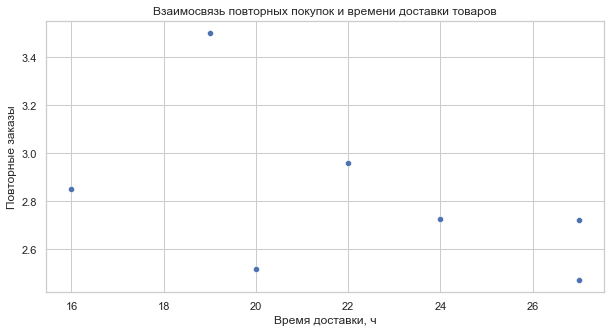

In [18]:
sns.set(style='whitegrid', rc={'figure.figsize' : (10,5)})
sns.scatterplot(x = 'deliv_time', y = 'rtn', data = df_rtn)
plt.title('Взаимосвязь повторных покупок и времени доставки товаров')
plt.xlabel('Время доставки, ч')
plt.ylabel('Повторные заказы')

In [19]:
df_rtn.corr()

,city,orders_count,user_count,rtn,deliv_time
city,1.000000,-0.591189,-0.592014,0.060881,0.201718
orders_count,-0.591189,1.000000,0.999177,-0.027150,0.470525
user_count,-0.592014,0.999177,1.000000,-0.067032,0.486865
rtn,0.060881,-0.027150,-0.067032,1.000000,-0.473505
deliv_time,0.201718,0.470525,0.486865,-0.473505,1.000000


Получили умеренную отрицательную корреляцию (-0.47) между повтрными покупками и временем доставки, так что необходимо разработать меры по сокращению времени доставки особенно в городах с id = 1 и 8

___

### Замены товаров

In [20]:
replacements = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/7kzDpj1u7B9osQ')
replacements.head()

,order_id,item_id,state
0,480785,6466916,replaced
1,480785,6466940,replaced
2,480785,6466778,replaced
3,480785,6466825,replaced
4,480786,7261201,replaced


In [21]:
cancellations = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/-xW2t5fsZIO_YA')
cancellations.head()

,order_id,item_id,state
0,480443,5333890,canceled
1,480443,5333777,canceled
2,480443,5334118,canceled
3,480452,5333731,canceled
4,480452,5333727,canceled


Проверим, в каком ретейлере наибольшее количество замен

In [22]:
orders_replace = orders_stores.merge(replacements, how = 'left', left_on = 'id_x', right_on = 'order_id'). \
                               merge(cancellations, how = 'left', left_on = 'id_x', right_on = 'order_id')

In [23]:
orders_replace = orders_replace.rename(columns={'id_x': 'orders_id', 'state_y': 'replace', 'state': 'cancel'})
orders_replace.head()

,orders_id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state_x,shipped_at,...,deliv_time,id_y,city,retailer_id,order_id_x,item_id_x,replace,order_id_y,item_id_y,cancel
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,...,12.0,1,1,1,NaN,NaN,NaN,756927.0,9447969.0,canceled
1,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,...,12.0,1,1,1,NaN,NaN,NaN,756927.0,9447940.0,canceled
2,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,...,12.0,1,1,1,NaN,NaN,NaN,756927.0,9447920.0,canceled
3,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,...,12.0,1,1,1,NaN,NaN,NaN,756927.0,9447558.0,canceled
4,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,...,12.0,1,1,1,NaN,NaN,NaN,756927.0,9447901.0,canceled


In [24]:
orders_replace.query('replace == "replaced" or cancel == "canceled"').groupby('retailer_id', as_index=False). \
                                                                     agg({'replace': 'count', 'cancel': 'count'})

,retailer_id,replace,cancel
0,1,2543443,2725007
1,8,296960,293303
2,15,456641,453277
3,16,2594,3179


In [25]:
orders_replace.groupby('retailer_id', as_index=False).agg({'orders_id': 'count'}).rename(columns={'orders_id': 'orders_count'})

,retailer_id,orders_count
0,1,3089637
1,8,331442
2,15,484285
3,16,4638


Т.к. ни один из ритейлеров не выделяется по заменам и отменам в заказах, то считаем, что проблема по заменам общая и не связана с обновлением ассортимента на сайте в конкретном ритейле и т.п. 

Посчитаем, какая доля пользователей не вернулась после отмен в первом же заказе

Найдем количество пользователей, у которых был только один заказ и в нем была отмена

In [26]:
df_a = orders_replace.groupby('user_id', as_index=False).agg({'orders_id': 'count', 'cancel': 'count'}). \
                      query('orders_id == 1 and cancel > 0').user_id.count()
df_a

17834

Найдем всех пользователей, у которых была отмена в первом заказе, независимо от того, вернулись они потом или нет

Выберем все первые заказы

In [27]:
df_b = orders_replace.groupby('user_id', as_index=False).agg({'created_at': 'min'}) 

Объединим с первоначальным датафреймом, где были отмены

In [28]:
df_first_canc=df_b.merge(orders_replace.query('cancel == "canceled"'), on = ['user_id', 'created_at'])

In [29]:
df_c=df_first_canc.user_id.nunique()

Теперь посчитаем долю невернувшихся

In [30]:
churn_canc = df_a / df_c
churn_canc

0.11660095848943111

Посчитаем то же для замен в первом и единственном заказе

In [31]:
df_d = orders_replace.groupby('user_id', as_index=False).agg({'orders_id': 'count', 'replace': 'count'}). \
                      query('orders_id == 1 and replace > 0').user_id.count()
df_d

17379

Теперь найдем всех, у кого в первом заказе была отмена

In [32]:
df_first_rep=df_b.merge(orders_replace.query('replace == "replaced"'), on = ['user_id', 'created_at'])

In [33]:
df_e=df_first_rep.user_id.nunique()

In [34]:
churn_replace = df_d / df_e
churn_replace

0.126449744612116

Сравним с долей не вернувшихся, у кого не было ни замен, ни отмен в первом заказе

In [35]:
df_f = orders_replace.groupby('user_id', as_index=False).agg({'orders_id': 'count', 'replace': 'count', 'cancel': 'count'}). \
                      query('orders_id == 1 and replace == 0 and cancel == 0').user_id.count()
df_f

39369

In [37]:
df_first=df_b.merge(orders_replace.query('cancel != "canceled" and replace != "replaced"'), on = ['user_id', 'created_at'])

In [38]:
df_g=df_first.user_id.nunique()

In [39]:
churn = df_f / df_g
churn

0.6384231180877631

Учитывая, что доля невернувшихся покупателей, у которых в первом заказе не было отмен и замен, даже выше, то не можем утверждать, что отмены и замены так сильно влияют на лояльность, несмотря на отзывы.

___

### Заказы в зависимости от дат

Оценим период данных заказов

In [41]:
orders_replace.created_at.describe()

<ipython-input-41-51049d042d1e>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders_replace.created_at.describe()


count                 3910002
unique                 703953
top       2019-10-16 13:26:20
freq                     1649
first     2018-08-26 00:05:41
last      2019-12-18 18:02:41
Name: created_at, dtype: object

Учитывая, что в период входит целый год, посмотрим динамику заказов по месяцам

In [59]:
orders['month']=orders.created_at.apply(lambda c: c.month)

In [67]:
df_month=orders.query('created_at > "2018-12-18 18:02:41"').groupby('month', as_index=False).agg({'item_total': 'sum'})
df_month.head()

,month,item_total
0,1,92236652
1,2,85034033
2,3,95615010
3,4,119566545
4,5,147003564


<AxesSubplot:xlabel='month', ylabel='item_total'>

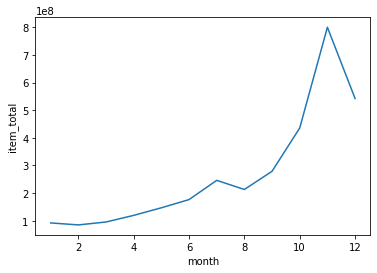

In [66]:
sns.lineplot(x="month", y="item_total",
             data=df_month)

Явный пик наблюдаем в ноябре, возможно связанный с черной пятницей

Есть ли увеличение в канун праздников? Рассмотрим март и декабрь

In [77]:
march=orders.query('month == 3').groupby('created_at', as_index=False).agg({'item_total': 'sum'})

In [78]:
march.created_at=march.created_at.apply(lambda c: c.day)

In [81]:
march=march.groupby('created_at', as_index=False).agg({'item_total': 'sum'}).sort_values('item_total', ascending=False)
march.head()

,created_at,item_total
4,5,3572548
14,15,3566342
3,4,3562909
5,6,3559815
6,7,3539247


<AxesSubplot:xlabel='created_at', ylabel='item_total'>

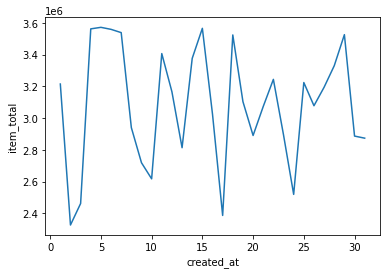

In [80]:
sns.lineplot(x="created_at", y="item_total",
             data=march)

Прирост выручки перед 8 Марта наблюдается, но пики не сильно выше, чем в другие удачные дни. Так что, возможно, стоит усилить акционную деятельность перед праздником

In [82]:
dec=orders.query('month == 12').groupby('created_at', as_index=False).agg({'item_total': 'sum'})

In [84]:
dec.created_at=dec.created_at.apply(lambda c: c.day)

In [85]:
dec=dec.groupby('created_at', as_index=False).agg({'item_total': 'sum'}).sort_values('item_total', ascending=False)
dec.head()

,created_at,item_total
10,11,36639007
11,12,36286288
8,9,35392841
9,10,35132118
5,6,33535919


<AxesSubplot:xlabel='created_at', ylabel='item_total'>

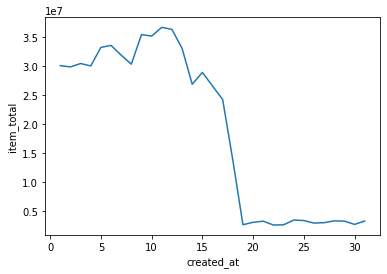

In [86]:
sns.lineplot(x="created_at", y="item_total",
             data=dec)

В конце декабря наблюдается спад заказов, что выглядит аномально. Необходимо сравнить с другими годами - типично ли такое поведение покупателей. Возможно стоит усилить рекламу и акции непосредственно перед НГ 

___

### Найдем ТОП-10 покупателей по выручке

In [88]:
orders.groupby('user_id', as_index=False).agg({'item_total': 'sum'}).sort_values('item_total', ascending=False).head(10)

,user_id,item_total
3400,32490,8510330
6525,56017,6583297
17186,129033,4016746
32873,171371,3912414
30293,165626,3886481
4537,42230,3655422
78002,314205,3643684
17485,130543,2661892
13144,106237,2302839
3262,31050,2224583


### Найдем ТОП-10 покупателей по количеству сделанных заказов

In [90]:
orders.groupby('user_id', as_index=False).agg({'id': 'count'}).sort_values('id', ascending=False).head(10)

,user_id,id
6525,56017,493
17186,129033,427
2554,25097,422
48877,215536,405
4537,42230,243
78002,314205,237
51811,224255,230
75447,304851,219
31939,169167,217
17485,130543,213


Данных пользователей необходимо рассмотреть в первую очередь для предложения персональных скидок и подобных акций

## Выводы
- Время доставки часто выше заявленного "Привезем в тот же день", что оказывает некоторое влияние на повторные покупки.
- Нет видимых причин считать, что отмены и замены в заказах сильно влияют на отток клиентов, не смотря на отзывы.
- Нет явного увеличения по заказам в канун 8 Марта и Нового Года (где есть даже аномальный спад), что может свидетельствовать о недостаточных рекламных компаниях и акциях.
- ТОП покупателей по заказам и по выручке, возможно, стоит рассмотреть для предложения индивидуальных условий.